In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spei as si 
import geopandas as gpd
from shapely.geometry import Point

### Import stations data

In [2]:
streamflow_data = "//gmvstorage.gmv.es/storage/anin/Streamflow/processed_data/clean_streamflow.xlsx"
df_streamflow = pd.read_excel(streamflow_data, index_col=0)

metadata = "//gmvstorage.gmv.es/storage/anin/Streamflow/processed_data/clean_metadata.xlsx"
df_metadata = pd.read_excel(metadata, index_col=0)

# Simplify the metadata to just keep the station names and geographical coordinates

df_metadata = df_metadata.set_index('STATION')[['LONGITUDE', 'LATITUDE']]


### Import boundaries for spatial distribution

In [3]:
# Read the shapefile
# shapefile_path = '//gmvstorage.gmv.es/storage/anin/South_African_secondaryCatchments/Secondary Catchment.shp'
shapefile_path = '//gmvstorage.gmv.es/storage/anin/Groundwater/2011 Freshwater Ecosystem Priority Areas 9 Water Management Areas/9WMA.shp'

areas = gpd.read_file(shapefile_path)

# Field in the shapefile table of attributes to be used for the averaging of the SGI in this case  "SECONDARY" for secondary catchments
grouping_field = 'WMA_NewN' 

In [4]:
# Import the modified sgi function which includes scaling 
from ssfi_tools import compute_ssfi

In [5]:
# Define index scale factor and distribution
scale = 3

# Create a new DataFrame to store the SGI values
df_ssfi = pd.DataFrame()

# Apply the SGI function to each column of the DataFrame

for column in df_streamflow.columns:
    df_ssfi[column] = compute_ssfi(df_streamflow[column],scale)

# Reset the index & Transpose the DataFrame
dates = df_ssfi.index.to_pydatetime()
df_ssfi = df_ssfi.reset_index(drop = True)
df_ssfi = df_ssfi.T

C:\Users\ecig\AppData\Local\Temp\ipykernel_21232\1832167417.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ssfi[column] = compute_ssfi(df_streamflow[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_21232\1832167417.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ssfi[column] = compute_ssfi(df_streamflow[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_21232\1832167417.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

#### Perform the average of the SGI values at each timestep for each polygon in the shapefile

In [6]:
# Join with coordinate information in metadata dataframe
df_latlon = df_ssfi.join(df_metadata)

# Convert the stations dataframe into a GeoDataFrame by specifying the geometry column with the coordinates:

geometry = [Point(xy) for xy in zip(df_latlon['LONGITUDE'], df_latlon['LATITUDE'])]
stations_gdf = gpd.GeoDataFrame(df_latlon, geometry=geometry)

# Perform a spatial join between the polygons and the stations to determine which stations fall within each polygon:
stations_by_polygon = gpd.sjoin(areas, stations_gdf, how='inner', op='contains')

# Select the columns based on their numeric names
time_step_columns = [col for col in stations_by_polygon.columns if str(col).isdigit()]

# Group the stations by polygon and time step, and calculate the average for each group:
ssfi_averages = stations_by_polygon.groupby([grouping_field])[time_step_columns].mean()

# Remove the time step columns from the stations_by_polygon
stations_by_polygon = stations_by_polygon.drop(columns=time_step_columns)

# Set the CRS of the GeoDataFrame
mycrs = 'EPSG:4326'
stations_by_polygon.crs = mycrs


c:\Users\ecig\Anaconda3\envs\geoTools\lib\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\ecig\AppData\Local\Temp\ipykernel_21232\446341496.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  stations_by_polygon = gpd.sjoin(areas, stations_gdf, how='inner', op='contains')


#### Plot the resulting time series by area

<Figure size 640x480 with 0 Axes>

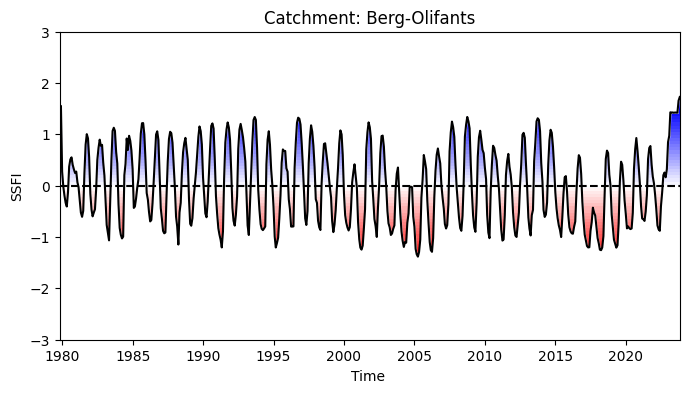

<Figure size 640x480 with 0 Axes>

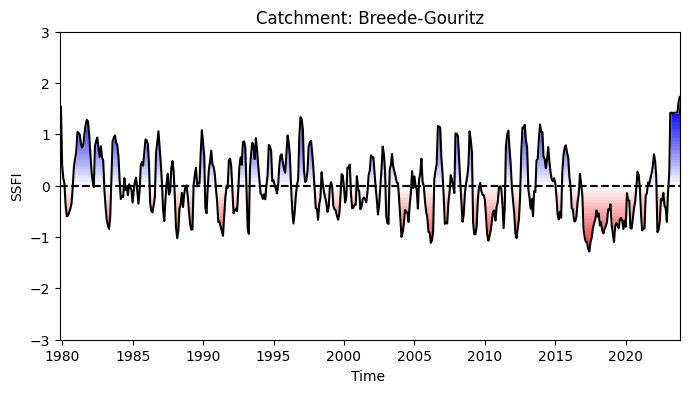

<Figure size 640x480 with 0 Axes>

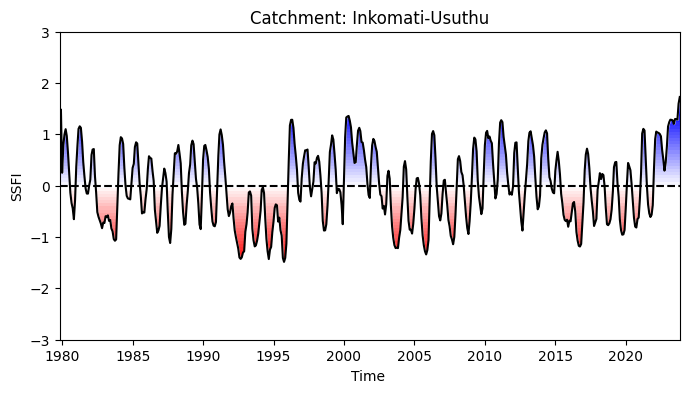

<Figure size 640x480 with 0 Axes>

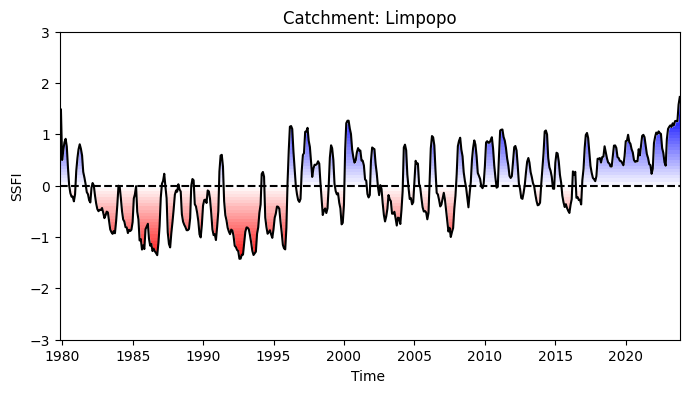

<Figure size 640x480 with 0 Axes>

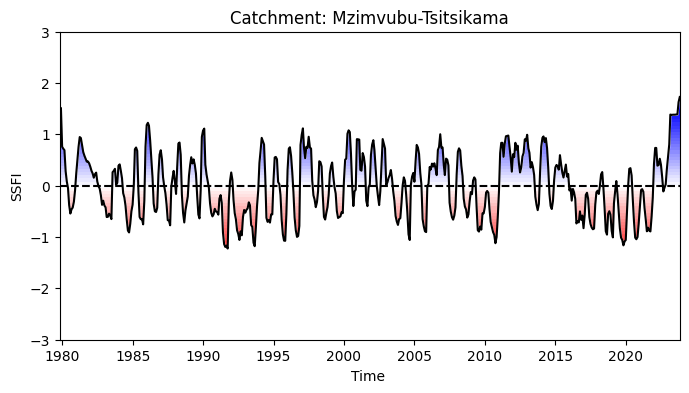

<Figure size 640x480 with 0 Axes>

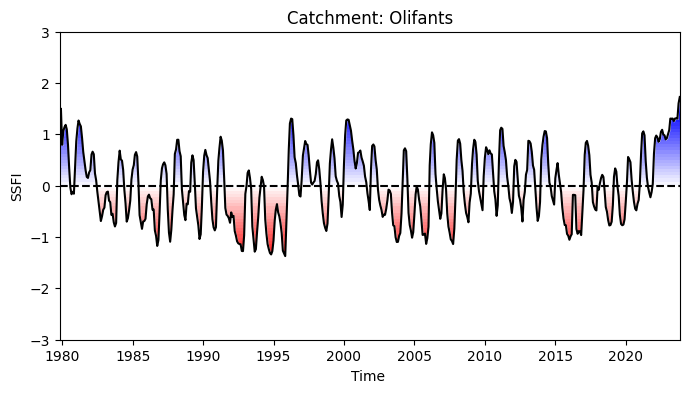

<Figure size 640x480 with 0 Axes>

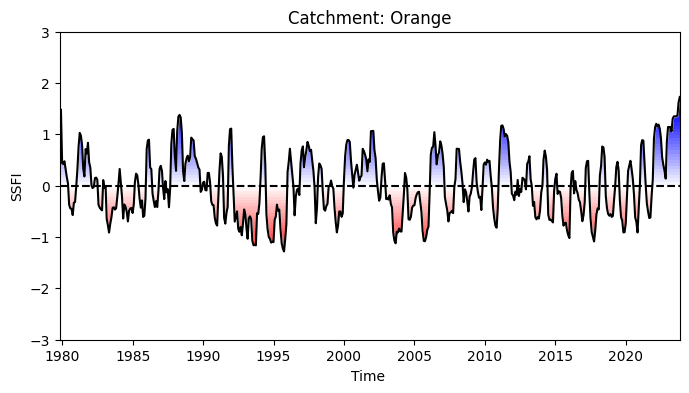

<Figure size 640x480 with 0 Axes>

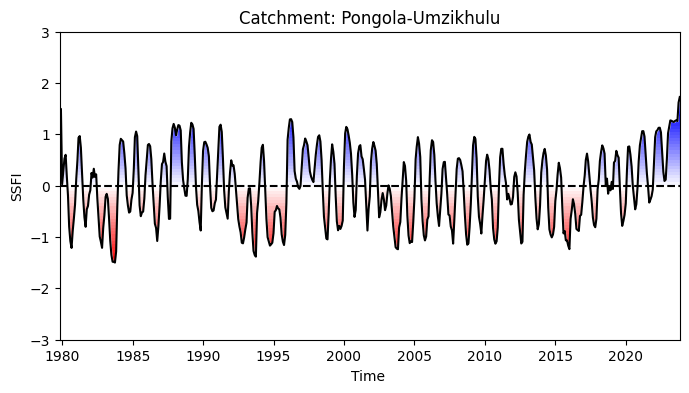

<Figure size 640x480 with 0 Axes>

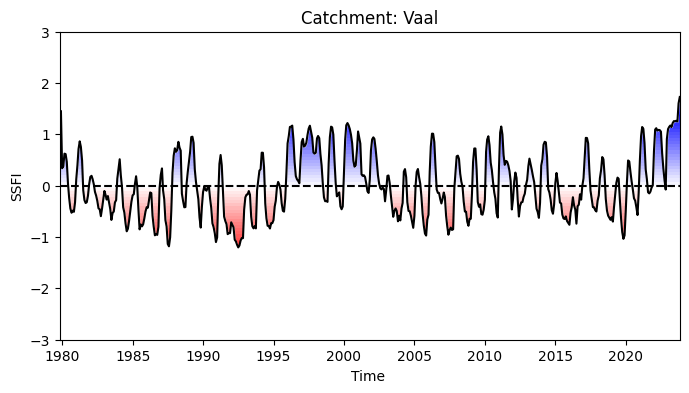

In [8]:

# Iterate through the rows of the averages DataFrame
for index, row in ssfi_averages.iterrows():
    # Extract the polygon ID from the index
    polygon_id = index

    # Create a pandas time series for the plot function to work
    time_series = pd.Series(row.values, index=dates)
    
    # Create a plot for the current row
    plt.figure()

    # Plot the average values for each time step
    si.plot.si(time_series)

    # Set plot title and labels
    plt.title(f"Catchment: {polygon_id}")
    plt.xlabel("Time ")
    plt.ylabel("SSFI")

    # Save the plots
    plt.savefig(f'//gmvstorage.gmv.es/storage/anin/Streamflow/outputs/SSFI/Ecoregions_TS/{polygon_id}.png')
